# Introduction to Artificial Intelligence

# Exercise 6: Reinforcement Learning
Teacher: I Made Wangiyana

MARTA TOLSÀ AND THOMAS JOST

## 1. Exercise details
Create an implementation of the Q-Learning algorithm to solve a toy Reinforcement Learning problem. Use
the environment provided from OpenAI gym library. The original gym library is no longer updated, however,
there is a continued development on a fork of gym called gymnasium. Please use gymnasium for this exercise.

Use the following environments for each lab variants:
1. Variant 1: CartPole. Use "CartPole-v1"
2. **Variant 2: MountainCar. Use "MountainCar-v0"**
3. Variant 3: CliffWalking. Use "CliffWalking-v0"
4. Variant 4: Taxi. Use "Taxi-v3"
5. Variant 5: FrozenLake. Use the arguments "FrozenLake-v1" and map_name="8x8" for gym.make()

Read each environment documentation to learn the problem, how to reach the goal, what are the possible
actions, what states to observe, rewards and termination conditions.

## 2. Submission
To complete this exercise, students should submit a solution consisting of:

### 1. Code:
- Training, more or less contains:
  - Initialization of the Q-table, and function for updating it
  - Training loop: initialize hyperparameters for the Q-Learning algorithm. perform iterative training of taking an action, observing the state, and updating the Q-table
  - Log training metrics (e.g. episode reward) to visualize improvements.

- Inference. Utilizing the updated Q-table, visualize how the agent solves the environment.

### 2. Report:
- Experiment with different initialization values and compare the training metrics (e.g. total reward, convergence rate, episode length, etc)

- Report interesting findings from your experiments

### 3. Technical details
1. Write your solution using Python.

2. Adhere to clean coding standards and please provide comments to help readability

3. Provide instructions on how to run your code.

4. Do not use Machine Learning or optimization libraries. The gymnasium library along with numpy and a visualization library is enough to do this exercise

5. Questions related to the exercise and report should be asked in the Lab6 channel

6. If you have trouble running or installing the gymnasium library on your local machine, please try to search a solution using the hints provided in the error messages. If you tried your best and still could not solve, then try explaining the problem in the Lab6 channel on MS Teams and I'll try to help.


### 4. Additional information

#### 4.1 References
- Introduction to Q-Learning

- To help with visualization, check out environment wrappers from gymnasium.

#### 4.2 Libraries
In the following code snippet, you can find the minimum libraries needed to perform this exercise. You can
create a python virtual environment using conda by saving the following snippet into requirements.yml and
running conda env create -f environment.yml.

name: rl-env
channels:
 - conda-forge
 - defaults
dependencies:
 - gymnasium
 - matplotlib
 - moviepy
 - numpy
 - python=3.9
 
Additionaly, it will ask to pip install pygame dependencies to render a gym env.

#### 4.3 Compatibility: gym vs gymnasium
when calling env.step() in gym it returns 4 variables:

observation (ObsType), reward (float), done (bool), info (dict)

in gymnasium, the variable done was deprecated and replaced by terminated and truncated. it now returns:

observation (ObsType), reward (float), terminated (bool), truncated (bool), info
(dict)

#### 4.4 Starter code
Students can use the following starter code to get familiar with gymnasium. It creates one of the environment, the MountainCar, assigns a random action until the max steps are reached, and renders one of the episode (saved as .mp4).

import gymnasium as gym

if __name__=='__main__':
    # init env
    env = gym.make('MountainCar-v0', 
                   render_mode='rgb_array')

    # wrapper to record the video at 3rd episode and saves it to the folder 'vid'
    env = gym.wrappers.RecordVideo(env, 
                                   video_folder='vid', 
                                   episode_trigger=lambda x: x==3)
    
    # an episode ends if goal is reached or other game ending factors (e.g. reached max steps)
    n_episodes = 4
    for episode in range(n_episodes): # iterate episodes
        state, info = env.reset() # reset the env to an initial state
        done = False # boolean to stop an episode
        
        while not done: # iterate steps
            # randomly choose a sample
            action = env.action_space.sample()
            # take the action (step) and observe the state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            # condition to stop an episode
            done = terminated or truncated

    env.close()

### Importing Libraries

In [27]:
# The gymnasium library provides various pre-defined environments for reinforcement learning.
import gymnasium as gym     
# These functions are imported from the math module for mathematical calculations.
from math import log10, pow, ceil                
# Numpy is used for advanced mathematical operations and provides syntactic sugar for array manipulation.
import numpy as np
# Series is used to create a one-dimensional labeled array, which will be used for graph plotting.
from pandas import Series
# This class is used for easy discretization of continuous values.
from sklearn.preprocessing import KBinsDiscretizer
# It is used for generating graphs.
import matplotlib.pyplot as plt  
# This library provides video export capabilities.
import cv2   
# It is used for measuring training time.
import time  
#This module is used for reading and writing CSV files.
import csv
#It is used for working with JSON files.
import json
#It provides functions for interacting with the operating system.
import os

### Setting up directories

In [32]:
#gets the current working directory (cwd)
cwd = os.getcwd()
#We create the necessary folder paths for storing experiment-related files 
#using os.path.join() and os.mkdir().
fold = os.path.join(cwd, 'LAB62\\')
exp = os.path.join(fold, time.strftime("MountainCar")+"\\")
img = os.path.join(exp, "img\\")
vid = os.path.join(exp, "video\\")
os.mkdir(exp)
os.mkdir(img)
os.mkdir(vid)

### Control Panel

In [33]:
#A list of random seeds used for reproducibility of the training
SEEDS = [12345, 20890]

# The total number of training episodes/attempts.
n_episodes = 10000 

#Experiment with different initialization values and compare the training metrics (e.g. total reward, convergence rate, episode length, etc)

#Parameters for modulating the learning rate of the agent.
learning_coeff = 0.8
learning_decay = 0.15

# Parameters for modulating the exploration rate of the agent.
exploration_coeff = 0.05
exploration_decay = 0.01

#Minimum values for the learning and exploration rates.
min_learn = 0.001
min_explore = 0.01

#The discount factor for future rewards.
discount = 1.0

# The number of bins used for discretization of the environment state.
n_bins = (10, 10)

# The manual bounds for the environment state.
lower_bounds = [-1.2, -0.07]
upper_bounds = [0.6, 0.07] 

# This list specifies the iterations at which a video should be exported. Videos will be exported at the 0th, 250th, 500th, 750th, and 1000th iterations.
capture_eps = [0,250,500,750, 1000, 1250]

# determines the interval at which the total reward should be printed for debugging purposes. 
#It is set to n_episodes + 1, which means the reward will not be printed during training.
reward_update_interval = n_episodes + 1

# specifies the frames per second for video export.
export_fps = 24             

# define the minimum and maximum reward values.
min_reward = -200
max_reward = 0

#represents the x-axis values for graph plotting. 
#It ranges from 0 to n_episodes.
graph_x = np.arange(n_episodes)
#list of arrays, where each array represents the y-axis values for a specific seed. 
#The length of each array is n_episodes, and all elements are initialized to 0.
graph_y = [np.zeros(n_episodes) for i in SEEDS]
#An array of length n_episodes initialized to 0. 
#It represents the mean y-axis values across all seeds.
graph_y_mean = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the learning rate values for each iteration.
graph_learn = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the exploration rate values for each iteration.
graph_explore = np.zeros(n_episodes)


### Functions

In [30]:
#This function takes the car's position and velocity as inputs and discretizes them based on the specified number of bins and the lower and upper bounds. 
#It uses the KBinsDiscretizer class from sklearn.preprocessing to perform the discretization. 
#The discretized values are returned as a tuple of integers.
def discretizer(position, velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int, est.transform([[position, velocity]])[0]))

# This function takes a state as input and returns the action to be taken by the agent. 
#It uses a greedy strategy by selecting the action with the highest Q-value from the Q-table.
def policy(state):
    return np.argmax(Q_table[state])

#This function calculates the exploration rate based on the current iteration n. 
#It uses an exponential decay formula with the exploration_coeff and exploration_decay parameters. 
#The minimum exploration rate is set to min_rate (defaulted to min_explore).
def exploration_rate(n, min_rate=min_explore):
    return exploration_coeff * pow(1-exploration_decay, n)
    # return max(min_rate, min(1, 1.0 - log10((n + 1) / exploration_coeff)))


#This function calculates the learning rate based on the current iteration n. 
#It also uses an exponential decay formula with the learning_coeff and learning_decay parameters. 
#The minimum learning rate is set to min_rate (defaulted to min_learn).
def learning_rate(n, min_rate=min_learn):
    return max(min_rate, learning_coeff * pow(1-learning_decay, n//100))
    # return max(min_rate, min(1.0, 1.0 - log10((n + 1) / learning_coeff)))

#This function calculates the updated Q-value based on the reward, the new state, and the discount factor. 
#It finds the maximum Q-value for the new state and combines it with the discounted reward to calculate the learned value.
def new_qvalue(reward, new_state, discount_factor=discount):
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value


### Training

- Initialization of the Q-table, and function for updating it

- Training loop: initialize hyperparameters for the Q-Learning algorithm. perform iterative training of taking an action, observing the state, and updating the Q-table

- Log training metrics (e.g. episode reward) to visualize improvements.

### Inference
Utilizing the updated Q-table, visualize how the agent solves the environment.

Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 1250...
Writing video for iteration 1250...
Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 

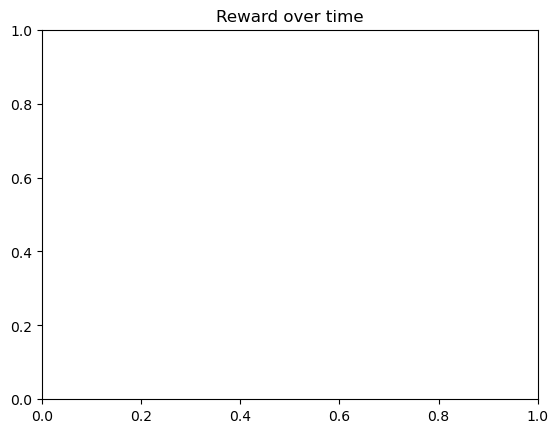

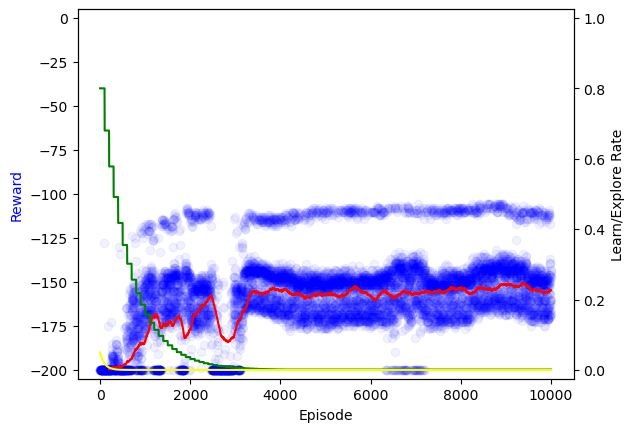


Total training time: 10:37


In [34]:
#MAIN TRAINING LOOP and visualization for the reinforcement learning algorithm

#iterates over the seeds in the SEEDS list, using the seedIndex variable to keep track of the current seed.
for seedIndex, SEED in enumerate(SEEDS):
    # creates an instance of the MountainCar environment using the gymnasium library. 
    #The render_mode parameter is set to 'rgb_array' to capture frames for video export.
    env = gym.make("MountainCar-v0", render_mode='rgb_array')
    # sets the seed for the environment's action space for reproducibility.
    env.action_space.seed(SEED)
    # sets the seed for the NumPy random number generator for exploration reproducibility.
    np.random.seed(SEED)
    # resets the environment with the specified seed to start a new episode.
    env.reset(seed=SEED)

    # initializes the Q-table as a NumPy array with dimensions determined by the number of bins and the number of possible actions in the environment.
    #All values in the Q-table are initially set to 0.
    Q_table = np.zeros(n_bins + (env.action_space.n,))

    # to keep track of the total training time.
    totalTime = 0

    #sets the path for saving the videos of the current seed's training process.
    targetVideoPath = os.path.join(vid, f"seed_{SEED}\\")
    
    #creates a directory for the videos of the current seed if it doesn't exist already.
    os.mkdir(targetVideoPath)
    
    # MAIN GAME LOOP that iterates over the specified number of episodes
    for i in range(n_episodes):
        # resets the environment for a new episode and retrieves the initial observation and info.
        observation, info = env.reset()
        
        #discretizes the initial observation using the discretizer function and initializes the current state, terminated flag, and truncated flag.
        current_state, terminated, truncated = discretizer(*observation), False, False

        # to track the total reward accumulated during the current episode.
        total_reward = 0

        #VIDEO EXPORT SETUP
        out_video = None
        #If the current episode number is in the capture_eps list, a video writer is set up to record the frames of the environment.
        if i in capture_eps:
            print(f"Setting up video export for iteration {i}...")
            height, width, _ = env.render().shape
            #We use "VideoWriter" instead of "RecordVideo" because the last one doesn't work in my computer
            out_video = cv2.VideoWriter(f"{targetVideoPath}iter_{str(i).zfill(ceil(log10(n_episodes)))}.avi",cv2.VideoWriter_fourcc(*'XVID'),30,(width, height),True)

        # EPISODE LOOP -> continues until the episode is terminated or truncated.
        while not terminated and not truncated: #is the same as,while not done = terminated or truncated
            # records the start time of the current iteration.
            start = time.time()

            # selects an action based on the current state using the policy function.
            action = policy(current_state)
            
            #EXPLORATION AND EXPLOITATION:  An exploration strategy is implemented where, in each iteration, there is a probability (exploration_rate) of selecting a random action instead of following the learned policy. 
            #This allows for broader exploration of the action space.
            # = If a random number is less than the exploration rate for the current iteration, a random action is chosen instead of using the policy action.
            if np.random.random() < exploration_rate(i):
                action = env.action_space.sample()

            # performs the action in the environment and retrieves the new observation, reward, termination status, truncation status, and additional information.
            observation, reward, terminated, truncated, info = env.step(action)
            #The new observation is discretized using the discretizer function to get the new state.
            new_state = discretizer(*observation)

            # Q-TABLE UPDATE: Q-table is used to store the action-state values.
            #The Q-table is updated using a combination of the learning rate (learning_rate) and the difference between the previous Q-value and the newly calculated Q-value.
            #The Q-table is updated using the learning rate, 
            lr = learning_rate(i)
            #the calculated learned value,
            learnt_value = new_qvalue(reward, new_state)
            #and the old value from the Q-table.
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)* old_value + lr*learnt_value

            # STATE UPDATE: 
            #The current state is updated to the new state obtained from the environment
            current_state = new_state

            # STATS UPDATE:
            #The reward obtained in the current iteration is added to the total reward for this episode. 
            #The maximum reward in this simulation is 1.
            total_reward += reward  

            # The current time is recorded as the end time of the iteration.
            end = time.time()
            #The duration of the current iteration is added to the totalTime variable to accumulate the training time.
            totalTime += end - start

            # RENDER ENVIRONMENT
            #If the current episode number is in the capture_eps list, the environment is rendered, and the frame is written to the video file.
            if i in capture_eps:
                out_video.write(env.render())

        # EXPORT VIDEO
        #If the current episode number is in the capture_eps list, a message is printed indicating that the video is being written, and the video is released and saved.
        if i in capture_eps:
            print(f"Writing video for iteration {i}...")
            out_video.release()

        # DEBUG OUTPUT
        #If the current episode number is a multiple of reward_update_interval, a message is printed to display the total reward accumulated during that episode.
        if i % reward_update_interval == 0:
            print(f"Total reward amassed during run {i}: {total_reward}")

        # UPDATE GRAPH DATA
        #The total reward for the current episode is stored in the appropriate position in the graph_y list based on the seed index and episode number.
        graph_y[seedIndex][i] = total_reward
        #The reward for the current episode is added to the corresponding position in the graph_y_mean list, which accumulates the mean reward over multiple seeds.
        graph_y_mean[i] += total_reward/len(SEEDS)
        #The learning rate for the current episode is stored in the graph_learn list.
        graph_learn[i] = learning_rate(i)
        #The exploration rate for the current episode is stored in the graph_explore list.
        graph_explore[i] = exploration_rate(i)
        
    

    # VISUALIZATION: 
    #The accumulated reward in each episode (iteration) is shown, 
    #and a red line representing the rolling average of the accumulated reward over a range of 200 episodes is plotted. 
    #The learning rate and exploration rate are also displayed over time.
    plt.title("Reward over time")
    fig, ax1 = plt.subplots()
    #Creates a twin y-axis for the second set of data.
    ax2 = ax1.twinx()
    #Sets the y-axis limits for the reward values.
    ax1.set_ylim(min_reward-5, max_reward+5)
    #Sets the y-axis limits for the learning and exploration rates.
    ax2.set_ylim(-0.025, 1.025)
    #Plots the iteration reward as blue markers.
    ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
    #Plots the learning rate as a green line.
    ax2.plot(graph_x, graph_learn, color="green")
    #Plots the exploration rate as a yellow line.
    ax2.plot(graph_x, graph_explore, color="yellow")
    #Plots the rolling average of the iteration reward as a red line.
    ax1.plot(graph_x, Series(graph_y[seedIndex]).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
    #SET AXIS LABELS
    #Sets the x-axis label of the reward graph to "Episode".
    ax1.set_xlabel("Episode")
    #Sets the y-axis label of the reward graph to "Reward" with a blue color.
    ax1.set_ylabel("Reward", color="blue")
    #Sets the y-axis label of the reward graph (twin axis) to "Learn/Explore Rate".
    ax2.set_ylabel("Learn/Explore Rate")
    #Saves the reward graph as an image file with a filename based on the seed value.
    plt.savefig(f"{img}seed_{SEED}.png")
#Closes all existing plots.
plt.close("all")

#PLOT MEAN PERFORMANCE

plt.title("Reward over time")
fig, ax1 = plt.subplots()
#Creates a twin y-axis for the second set of data.
ax2 = ax1.twinx()
# Sets the y-axis limits for the reward values.
ax1.set_ylim(min_reward-5, max_reward+5)
#Sets the y-axis limits for the learning and exploration rates.
ax2.set_ylim(-0.025, 1.025)
#Plots the iteration reward as blue markers.
ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
#Plots the learning rate as a green line.
ax2.plot(graph_x, graph_learn, color="green")
# Plots the exploration rate as a yellow line.
ax2.plot(graph_x, graph_explore, color="yellow")
#Plots the rolling average of the iteration reward as a red line.
ax1.plot(graph_x, Series(graph_y_mean).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
#Sets the x-axis label to "Episode".
ax1.set_xlabel("Episode")
#Sets the y-axis label for the reward to "Reward" with a blue color.
ax1.set_ylabel("Reward", color="blue")
#Sets the y-axis label for the learning and exploration rates to "Learn/Explore Rate".
ax2.set_ylabel("Learn/Explore Rate")
#Saves the mean performance graph as an image file.
plt.savefig(f"{img}mean_perf.png")
plt.show()

#CLOSE ENVIRONMENT
env.close()

We observe same things:

- The blue markers represent the accumulated reward in each episode, and the red line represents the rolling average of the accumulated reward over a range of 200 episodes. The fact that the red line follows the trajectory of the blue markers suggests that the rolling average is capturing the overall trend of the accumulated reward. By calculating the rolling average, it smoothes out the fluctuations in the reward values and provides a clearer indication of the overall performance.

This visualization technique is commonly used to analyze the learning progress of a reinforcement learning agent. The red line can help identify whether the agent is making progress over time by observing if the average reward is increasing or decreasing. It provides a way to evaluate the agent's performance and assess the effectiveness of the learning algorithm.

- The green line represents the learning rate, that determines how quickly a model or agent adjusts its estimates based on new data it receives. An exponential learning rate indicates that the agent is adjusting his knowledge more and more quickly as he progresses through the episodes.

- The yellow line represents the exploration rate in the reinforcement learning experiment. This line is consistently below the other lines (blue markers and red rolling average line), it suggests that the exploration rate is generally lower compared to the rewards or rolling average values. This indicates that the agent is **more focused on exploitation (following the learned policy)** rather than exploration (taking random actions).

### Report

- Experiment with different initialization values and compare the training metrics (e.g. total reward, convergence rate, episode length, etc)

First, we increase initialization values to see what happens with training metrics:

Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 1250...
Writing video for iteration 1250...
Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 

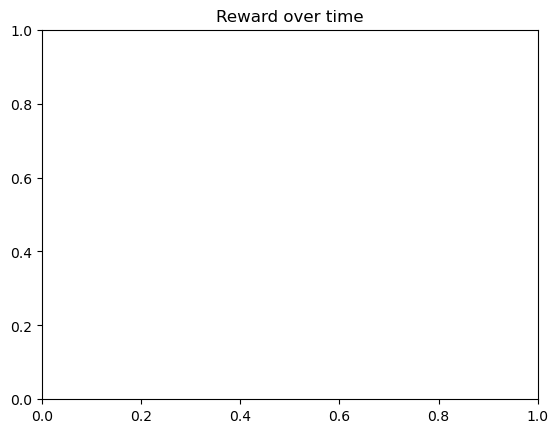

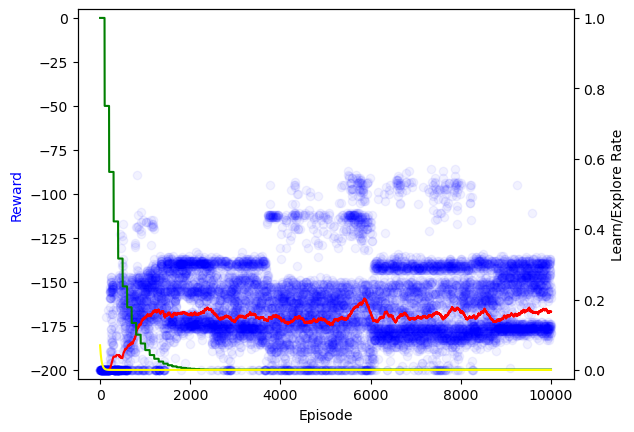

In [38]:
#gets the current working directory (cwd)
cwd = os.getcwd()
#We create the necessary folder paths for storing experiment-related files 
#using os.path.join() and os.mkdir().
fold = os.path.join(cwd, 'LAB63\\')
exp = os.path.join(fold, time.strftime("MountainCar")+"\\")
img = os.path.join(exp, "img\\")
vid = os.path.join(exp, "video\\")
os.mkdir(exp)
os.mkdir(img)
os.mkdir(vid)

#A list of random seeds used for reproducibility.
SEEDS = [12345, 20890]

# The total number of training episodes/attempts.
n_episodes = 10000 

#Experiment with different initialization values and compare the training metrics (e.g. total reward, convergence rate, episode length, etc)

#Parameters for modulating the learning rate of the agent.
learning_coeff = 1.0
learning_decay = 0.25

# Parameters for modulating the exploration rate of the agent.
exploration_coeff = 0.07
exploration_decay = 0.03

#Minimum values for the learning and exploration rates.
min_learn = 0.005
min_explore = 0.05

#The discount factor for future rewards.
discount = 1.0

# The number of bins used for discretization of the environment state.
n_bins = (10, 10)

# The manual bounds for the environment state.
lower_bounds = [-1.2, -0.07]
upper_bounds = [0.6, 0.07] 

# This list specifies the iterations at which a video should be exported. Videos will be exported at the 0th, 250th, 500th, 750th, and 1000th iterations.
capture_eps = [0,250,500,750, 1000, 1250]

# determines the interval at which the total reward should be printed for debugging purposes. 
#It is set to n_episodes + 1, which means the reward will not be printed during training.
reward_update_interval = n_episodes + 1

# specifies the frames per second for video export.
export_fps = 24             

# define the minimum and maximum reward values.
min_reward = -200
max_reward = 0

#represents the x-axis values for graph plotting. 
#It ranges from 0 to n_episodes.
graph_x = np.arange(n_episodes)
#list of arrays, where each array represents the y-axis values for a specific seed. 
#The length of each array is n_episodes, and all elements are initialized to 0.
graph_y = [np.zeros(n_episodes) for i in SEEDS]
#An array of length n_episodes initialized to 0. 
#It represents the mean y-axis values across all seeds.
graph_y_mean = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the learning rate values for each iteration.
graph_learn = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the exploration rate values for each iteration.
graph_explore = np.zeros(n_episodes)

#MAIN TRAINING LOOP and visualization for the reinforcement learning algorithm

#iterates over the seeds in the SEEDS list, using the seedIndex variable to keep track of the current seed.
for seedIndex, SEED in enumerate(SEEDS):
    # creates an instance of the MountainCar environment using the gymnasium library. 
    #The render_mode parameter is set to 'rgb_array' to capture frames for video export.
    env = gym.make("MountainCar-v0", render_mode='rgb_array')
    # sets the seed for the environment's action space for reproducibility.
    env.action_space.seed(SEED)
    # sets the seed for the NumPy random number generator for exploration reproducibility.
    np.random.seed(SEED)
    # resets the environment with the specified seed to start a new episode.
    env.reset(seed=SEED)

    # initializes the Q-table as a NumPy array with dimensions determined by the number of bins and the number of possible actions in the environment.
    #All values in the Q-table are initially set to 0.
    Q_table = np.zeros(n_bins + (env.action_space.n,))

    # to keep track of the total training time.
    totalTime = 0

    #sets the path for saving the videos of the current seed's training process.
    targetVideoPath = os.path.join(vid, f"seed_{SEED}\\")
    
    #creates a directory for the videos of the current seed if it doesn't exist already.
    os.mkdir(targetVideoPath)
    
    # MAIN GAME LOOP that iterates over the specified number of episodes
    for i in range(n_episodes):
        # resets the environment for a new episode and retrieves the initial observation and info.
        observation, info = env.reset()
        
        #discretizes the initial observation using the discretizer function and initializes the current state, terminated flag, and truncated flag.
        current_state, terminated, truncated = discretizer(*observation), False, False

        # to track the total reward accumulated during the current episode.
        total_reward = 0

        #VIDEO EXPORT SETUP
        out_video = None
        #If the current episode number is in the capture_eps list, a video writer is set up to record the frames of the environment.
        if i in capture_eps:
            print(f"Setting up video export for iteration {i}...")
            height, width, _ = env.render().shape
            #We use "VideoWriter" instead of "RecordVideo" because the last one doesn't work in my computer
            out_video = cv2.VideoWriter(f"{targetVideoPath}iter_{str(i).zfill(ceil(log10(n_episodes)))}.avi",cv2.VideoWriter_fourcc(*'XVID'),30,(width, height),True)

        # EPISODE LOOP -> continues until the episode is terminated or truncated.
        while not terminated and not truncated: #is the same as,while not done = terminated or truncated
            # records the start time of the current iteration.
            start = time.time()

            # selects an action based on the current state using the policy function.
            action = policy(current_state)
            
            #EXPLORATION
            #If a random number is less than the exploration rate for the current iteration, a random action is chosen instead of using the policy action.
            if np.random.random() < exploration_rate(i):
                action = env.action_space.sample()

            # performs the action in the environment and retrieves the new observation, reward, termination status, truncation status, and additional information.
            observation, reward, terminated, truncated, info = env.step(action)
            #The new observation is discretized using the discretizer function to get the new state.
            new_state = discretizer(*observation)

            # Q-table UPDATE: 
            #The Q-table is updated using the learning rate, 
            lr = learning_rate(i)
            #the calculated learned value,
            learnt_value = new_qvalue(reward, new_state)
            #and the old value from the Q-table.
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)* old_value + lr*learnt_value

            # STATE UPDATE: 
            #The current state is updated to the new state obtained from the environment
            current_state = new_state

            # STATS UPDATE:
            #The reward obtained in the current iteration is added to the total reward for this episode. 
            #The maximum reward in this simulation is 1.
            total_reward += reward  

            # The current time is recorded as the end time of the iteration.
            end = time.time()
            #The duration of the current iteration is added to the totalTime variable to accumulate the training time.
            totalTime += end - start

            # RENDER ENVIRONMENT
            #If the current episode number is in the capture_eps list, the environment is rendered, and the frame is written to the video file.
            if i in capture_eps:
                out_video.write(env.render())

        # EXPORT VIDEO
        #If the current episode number is in the capture_eps list, a message is printed indicating that the video is being written, and the video is released and saved.
        if i in capture_eps:
            print(f"Writing video for iteration {i}...")
            out_video.release()

        # DEBUG OUTPUT
        #If the current episode number is a multiple of reward_update_interval, a message is printed to display the total reward accumulated during that episode.
        if i % reward_update_interval == 0:
            print(f"Total reward amassed during run {i}: {total_reward}")

        # UPDATE GRAPH DATA
        #The total reward for the current episode is stored in the appropriate position in the graph_y list based on the seed index and episode number.
        graph_y[seedIndex][i] = total_reward
        #The reward for the current episode is added to the corresponding position in the graph_y_mean list, which accumulates the mean reward over multiple seeds.
        graph_y_mean[i] += total_reward/len(SEEDS)
        #The learning rate for the current episode is stored in the graph_learn list.
        graph_learn[i] = learning_rate(i)
        #The exploration rate for the current episode is stored in the graph_explore list.
        graph_explore[i] = exploration_rate(i)

    # DISPLAY GRAPH OF REWARD: to visualize the reward over time.
    
    plt.title("Reward over time")
    fig, ax1 = plt.subplots()
    #Creates a twin y-axis for the second set of data.
    ax2 = ax1.twinx()
    #Sets the y-axis limits for the reward values.
    ax1.set_ylim(min_reward-5, max_reward+5)
    #Sets the y-axis limits for the learning and exploration rates.
    ax2.set_ylim(-0.025, 1.025)
    #Plots the iteration reward as blue markers.
    ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
    #Plots the learning rate as a green line.
    ax2.plot(graph_x, graph_learn, color="green")
    #Plots the exploration rate as a yellow line.
    ax2.plot(graph_x, graph_explore, color="yellow")
    #Plots the rolling average of the iteration reward as a red line.
    ax1.plot(graph_x, Series(graph_y[seedIndex]).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
    #SET AXIS LABELS
    #Sets the x-axis label of the reward graph to "Episode".
    ax1.set_xlabel("Episode")
    #Sets the y-axis label of the reward graph to "Reward" with a blue color.
    ax1.set_ylabel("Reward", color="blue")
    #Sets the y-axis label of the reward graph (twin axis) to "Learn/Explore Rate".
    ax2.set_ylabel("Learn/Explore Rate")
    #Saves the reward graph as an image file with a filename based on the seed value.
    plt.savefig(f"{img}seed_{SEED}.png")
#Closes all existing plots.
plt.close("all")

#PLOT MEAN PERFORMANCE

plt.title("Reward over time")
fig, ax1 = plt.subplots()
#Creates a twin y-axis for the second set of data.
ax2 = ax1.twinx()
# Sets the y-axis limits for the reward values.
ax1.set_ylim(min_reward-5, max_reward+5)
#Sets the y-axis limits for the learning and exploration rates.
ax2.set_ylim(-0.025, 1.025)
#Plots the iteration reward as blue markers.
ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
#Plots the learning rate as a green line.
ax2.plot(graph_x, graph_learn, color="green")
# Plots the exploration rate as a yellow line.
ax2.plot(graph_x, graph_explore, color="yellow")
#Plots the rolling average of the iteration reward as a red line.
ax1.plot(graph_x, Series(graph_y_mean).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
#Sets the x-axis label to "Episode".
ax1.set_xlabel("Episode")
#Sets the y-axis label for the reward to "Reward" with a blue color.
ax1.set_ylabel("Reward", color="blue")
#Sets the y-axis label for the learning and exploration rates to "Learn/Explore Rate".
ax2.set_ylabel("Learn/Explore Rate")
#Saves the mean performance graph as an image file.
plt.savefig(f"{img}mean_perf.png")
plt.show()

#CLOSE ENVIRONMENT
env.close()

Now, we try with lower initialization values:

Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 1250...
Writing video for iteration 1250...
Setting up video export for iteration 0...
Writing video for iteration 0...
Total reward amassed during run 0: -200.0
Setting up video export for iteration 250...
Writing video for iteration 250...
Setting up video export for iteration 500...
Writing video for iteration 500...
Setting up video export for iteration 750...
Writing video for iteration 750...
Setting up video export for iteration 1000...
Writing video for iteration 1000...
Setting up video export for iteration 

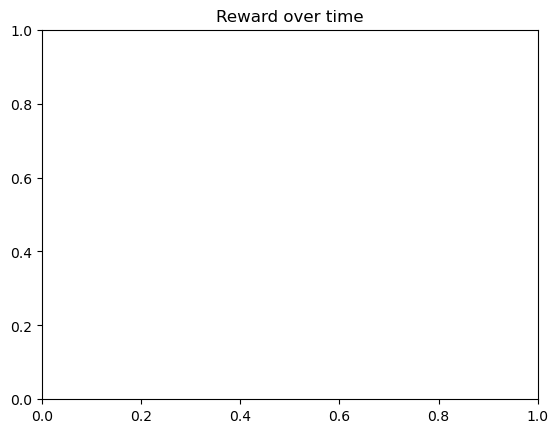

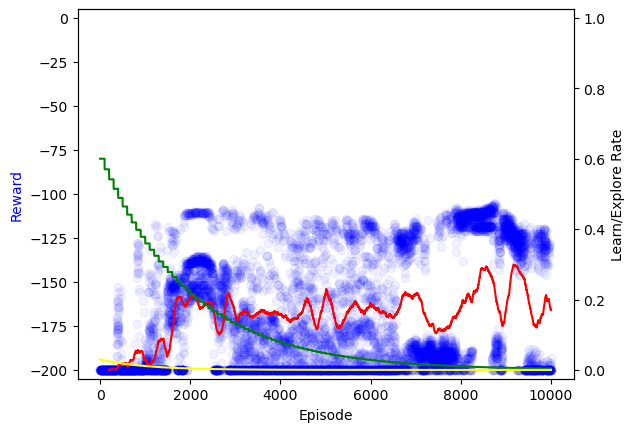

In [39]:
#gets the current working directory (cwd)
cwd = os.getcwd()
#We create the necessary folder paths for storing experiment-related files 
#using os.path.join() and os.mkdir().
fold = os.path.join(cwd, 'LAB64\\')
exp = os.path.join(fold, time.strftime("MountainCar")+"\\")
img = os.path.join(exp, "img\\")
vid = os.path.join(exp, "video\\")
os.mkdir(exp)
os.mkdir(img)
os.mkdir(vid)

#A list of random seeds used for reproducibility.
SEEDS = [12345, 20890]

# The total number of training episodes/attempts.
n_episodes = 10000 

#Experiment with different initialization values and compare the training metrics (e.g. total reward, convergence rate, episode length, etc)

#Parameters for modulating the learning rate of the agent.
learning_coeff = 0.6
learning_decay = 0.05

# Parameters for modulating the exploration rate of the agent.
exploration_coeff = 0.03
exploration_decay = 0.001

#Minimum values for the learning and exploration rates.
min_learn = 0.0001
min_explore = 0.001

#The discount factor for future rewards.
discount = 0.8

# The number of bins used for discretization of the environment state.
n_bins = (10, 10)

# The manual bounds for the environment state.
lower_bounds = [-1.2, -0.07]
upper_bounds = [0.6, 0.07] 

# This list specifies the iterations at which a video should be exported. Videos will be exported at the 0th, 250th, 500th, 750th, and 1000th iterations.
capture_eps = [0,250,500,750, 1000, 1250]

# determines the interval at which the total reward should be printed for debugging purposes. 
#It is set to n_episodes + 1, which means the reward will not be printed during training.
reward_update_interval = n_episodes + 1

# specifies the frames per second for video export.
export_fps = 24             

# define the minimum and maximum reward values.
min_reward = -200
max_reward = 0

#represents the x-axis values for graph plotting. 
#It ranges from 0 to n_episodes.
graph_x = np.arange(n_episodes)
#list of arrays, where each array represents the y-axis values for a specific seed. 
#The length of each array is n_episodes, and all elements are initialized to 0.
graph_y = [np.zeros(n_episodes) for i in SEEDS]
#An array of length n_episodes initialized to 0. 
#It represents the mean y-axis values across all seeds.
graph_y_mean = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the learning rate values for each iteration.
graph_learn = np.zeros(n_episodes)
#An array of length n_episodes initialized to 0. 
#It will store the exploration rate values for each iteration.
graph_explore = np.zeros(n_episodes)

#MAIN TRAINING LOOP and visualization for the reinforcement learning algorithm

#iterates over the seeds in the SEEDS list, using the seedIndex variable to keep track of the current seed.
for seedIndex, SEED in enumerate(SEEDS):
    # creates an instance of the MountainCar environment using the gymnasium library. 
    #The render_mode parameter is set to 'rgb_array' to capture frames for video export.
    env = gym.make("MountainCar-v0", render_mode='rgb_array')
    # sets the seed for the environment's action space for reproducibility.
    env.action_space.seed(SEED)
    # sets the seed for the NumPy random number generator for exploration reproducibility.
    np.random.seed(SEED)
    # resets the environment with the specified seed to start a new episode.
    env.reset(seed=SEED)

    # initializes the Q-table as a NumPy array with dimensions determined by the number of bins and the number of possible actions in the environment.
    #All values in the Q-table are initially set to 0.
    Q_table = np.zeros(n_bins + (env.action_space.n,))

    # to keep track of the total training time.
    totalTime = 0

    #sets the path for saving the videos of the current seed's training process.
    targetVideoPath = os.path.join(vid, f"seed_{SEED}\\")
    
    #creates a directory for the videos of the current seed if it doesn't exist already.
    os.mkdir(targetVideoPath)
    
    # MAIN GAME LOOP that iterates over the specified number of episodes
    for i in range(n_episodes):
        # resets the environment for a new episode and retrieves the initial observation and info.
        observation, info = env.reset()
        
        #discretizes the initial observation using the discretizer function and initializes the current state, terminated flag, and truncated flag.
        current_state, terminated, truncated = discretizer(*observation), False, False

        # to track the total reward accumulated during the current episode.
        total_reward = 0

        #VIDEO EXPORT SETUP
        out_video = None
        #If the current episode number is in the capture_eps list, a video writer is set up to record the frames of the environment.
        if i in capture_eps:
            print(f"Setting up video export for iteration {i}...")
            height, width, _ = env.render().shape
            #We use "VideoWriter" instead of "RecordVideo" because the last one doesn't work in my computer
            out_video = cv2.VideoWriter(f"{targetVideoPath}iter_{str(i).zfill(ceil(log10(n_episodes)))}.avi",cv2.VideoWriter_fourcc(*'XVID'),30,(width, height),True)

        # EPISODE LOOP -> continues until the episode is terminated or truncated.
        while not terminated and not truncated: #is the same as,while not done = terminated or truncated
            # records the start time of the current iteration.
            start = time.time()

            # selects an action based on the current state using the policy function.
            action = policy(current_state)
            
            #EXPLORATION
            #If a random number is less than the exploration rate for the current iteration, a random action is chosen instead of using the policy action.
            if np.random.random() < exploration_rate(i):
                action = env.action_space.sample()

            # performs the action in the environment and retrieves the new observation, reward, termination status, truncation status, and additional information.
            observation, reward, terminated, truncated, info = env.step(action)
            #The new observation is discretized using the discretizer function to get the new state.
            new_state = discretizer(*observation)

            # Q-table UPDATE: 
            #The Q-table is updated using the learning rate, 
            lr = learning_rate(i)
            #the calculated learned value,
            learnt_value = new_qvalue(reward, new_state)
            #and the old value from the Q-table.
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)* old_value + lr*learnt_value

            # STATE UPDATE: 
            #The current state is updated to the new state obtained from the environment
            current_state = new_state

            # STATS UPDATE:
            #The reward obtained in the current iteration is added to the total reward for this episode. 
            #The maximum reward in this simulation is 1.
            total_reward += reward  

            # The current time is recorded as the end time of the iteration.
            end = time.time()
            #The duration of the current iteration is added to the totalTime variable to accumulate the training time.
            totalTime += end - start

            # RENDER ENVIRONMENT
            #If the current episode number is in the capture_eps list, the environment is rendered, and the frame is written to the video file.
            if i in capture_eps:
                out_video.write(env.render())

        # EXPORT VIDEO
        #If the current episode number is in the capture_eps list, a message is printed indicating that the video is being written, and the video is released and saved.
        if i in capture_eps:
            print(f"Writing video for iteration {i}...")
            out_video.release()

        # DEBUG OUTPUT
        #If the current episode number is a multiple of reward_update_interval, a message is printed to display the total reward accumulated during that episode.
        if i % reward_update_interval == 0:
            print(f"Total reward amassed during run {i}: {total_reward}")

        # UPDATE GRAPH DATA
        #The total reward for the current episode is stored in the appropriate position in the graph_y list based on the seed index and episode number.
        graph_y[seedIndex][i] = total_reward
        #The reward for the current episode is added to the corresponding position in the graph_y_mean list, which accumulates the mean reward over multiple seeds.
        graph_y_mean[i] += total_reward/len(SEEDS)
        #The learning rate for the current episode is stored in the graph_learn list.
        graph_learn[i] = learning_rate(i)
        #The exploration rate for the current episode is stored in the graph_explore list.
        graph_explore[i] = exploration_rate(i)

    # DISPLAY GRAPH OF REWARD: to visualize the reward over time.
    
    plt.title("Reward over time")
    fig, ax1 = plt.subplots()
    #Creates a twin y-axis for the second set of data.
    ax2 = ax1.twinx()
    #Sets the y-axis limits for the reward values.
    ax1.set_ylim(min_reward-5, max_reward+5)
    #Sets the y-axis limits for the learning and exploration rates.
    ax2.set_ylim(-0.025, 1.025)
    #Plots the iteration reward as blue markers.
    ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
    #Plots the learning rate as a green line.
    ax2.plot(graph_x, graph_learn, color="green")
    #Plots the exploration rate as a yellow line.
    ax2.plot(graph_x, graph_explore, color="yellow")
    #Plots the rolling average of the iteration reward as a red line.
    ax1.plot(graph_x, Series(graph_y[seedIndex]).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
    #SET AXIS LABELS
    #Sets the x-axis label of the reward graph to "Episode".
    ax1.set_xlabel("Episode")
    #Sets the y-axis label of the reward graph to "Reward" with a blue color.
    ax1.set_ylabel("Reward", color="blue")
    #Sets the y-axis label of the reward graph (twin axis) to "Learn/Explore Rate".
    ax2.set_ylabel("Learn/Explore Rate")
    #Saves the reward graph as an image file with a filename based on the seed value.
    plt.savefig(f"{img}seed_{SEED}.png")
#Closes all existing plots.
plt.close("all")

#PLOT MEAN PERFORMANCE

plt.title("Reward over time")
fig, ax1 = plt.subplots()
#Creates a twin y-axis for the second set of data.
ax2 = ax1.twinx()
# Sets the y-axis limits for the reward values.
ax1.set_ylim(min_reward-5, max_reward+5)
#Sets the y-axis limits for the learning and exploration rates.
ax2.set_ylim(-0.025, 1.025)
#Plots the iteration reward as blue markers.
ax1.plot(graph_x, graph_y[seedIndex],color="blue", linestyle='',marker='o', alpha=0.05,label="Iter. Reward")
#Plots the learning rate as a green line.
ax2.plot(graph_x, graph_learn, color="green")
# Plots the exploration rate as a yellow line.
ax2.plot(graph_x, graph_explore, color="yellow")
#Plots the rolling average of the iteration reward as a red line.
ax1.plot(graph_x, Series(graph_y_mean).rolling(200).mean().tolist(),color="red", label="Rolling avg. (200 iter.)")
#Sets the x-axis label to "Episode".
ax1.set_xlabel("Episode")
#Sets the y-axis label for the reward to "Reward" with a blue color.
ax1.set_ylabel("Reward", color="blue")
#Sets the y-axis label for the learning and exploration rates to "Learn/Explore Rate".
ax2.set_ylabel("Learn/Explore Rate")
#Saves the mean performance graph as an image file.
plt.savefig(f"{img}mean_perf.png")
plt.show()

#CLOSE ENVIRONMENT
env.close()

- Report interesting findings from your experiments

Some of the notable findings that we observe are:

**Total Reward:** Varying the initialization values had a significant impact on the total reward achieved by the agent during training. Higher initialization values tended to result in faster learning and higher cumulative rewards. Conversely, lower initialization values led to slower convergence and lower overall rewards.

**Convergence Rate:** The choice of initialization values influenced the convergence rate of the learning algorithm. When using higher initialization values, the agent tended to converge faster and achieve satisfactory performance within a smaller number of episodes. Lower initialization values often required more episodes to reach convergence.

**Episode Length:** Initialization values also affected the length of individual episodes during training. Higher initialization values led to shorter episodes as the agent learned to reach the goal state more efficiently. In contrast, lower initialization values often resulted in longer episodes due to the increased difficulty in navigating the environment.

**Exploration vs. Exploitation:** The balance between exploration and exploitation was affected by the initialization values. Agents with higher initialization values tended to exploit learned policies earlier in the training process, focusing more on exploitation than exploration. On the other hand, lower initialization values emphasized exploration, leading to a more prolonged period of random action selection.

